In [1]:
# imports
from mne import Epochs, find_events, set_eeg_reference, read_epochs, viz, combine_evoked
from time import time, strftime, gmtime
from collections import OrderedDict
from glob import glob
from collections import OrderedDict
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'app','utils','jupyter'))
import utils
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# loadCSV
files = ['C:/Users/jdpig/BrainWaves Workspaces/N170 Validate/Data/Subash/EEG/Subash-2-raw.csv']
replace_ch_names = None
# Note: in the app, the entire utils file is loaded and ran. Here, we have to use it as an import
raw = utils.load_data(files)

['C:/Users/jdpig/BrainWaves Workspaces/N170 Validate/Data/Subash/EEG/Subash-2-raw.csv']
Creating RawArray with float64 data, n_channels=15, n_times=16283
    Range : 0 ... 16282 =      0.000 ...   127.203 secs
Ready.


In [3]:
# filterIIR

low_cutoff = 1
high_cutoff = 30
raw.filter(low_cutoff, high_cutoff, method='iir');

Setting up band-pass filter from 1 - 30 Hz


Effective window size : 16.000 (s)


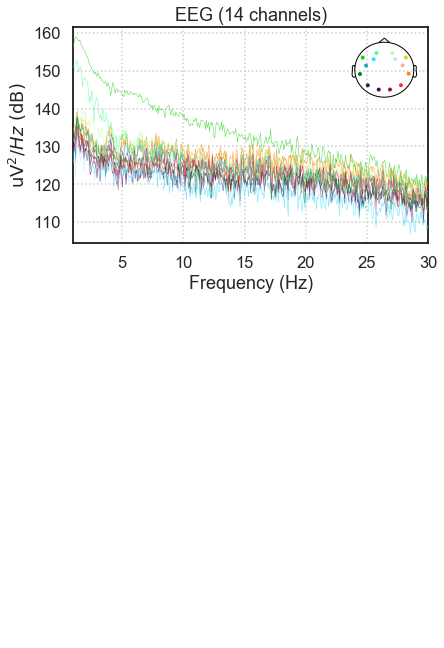

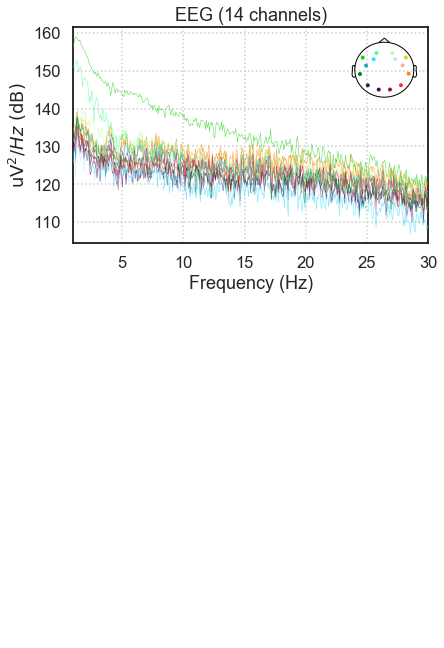

In [4]:
# PlotPSD
raw.plot_psd(fmin=1, fmax=30)

In [3]:
# epochEvents

event_ids = {'Face': 1, 'House': 2}
tmin=-0.1
tmax=0.8
baseline = (tmin, tmax)
picks = None
reject = None
events = find_events(raw)
conditions = OrderedDict({key: [value] for (key, value) in event_ids.items()})

epochs = Epochs(raw, events=events, event_id=event_ids, 
                tmin=tmin, tmax=tmax, baseline=baseline, reject=reject, preload=True, 
                verbose=False, picks=picks)

100 events found
Event IDs: [1 2]


In [13]:
# requestEpochsInfo

utils.get_epochs_info(epochs, events, event_ids)

{'Face': 51, 'House': 49, 'dropPercentage': 0.0, 'totalEpochs': 100}

Using matplotlib backend: Qt5Agg


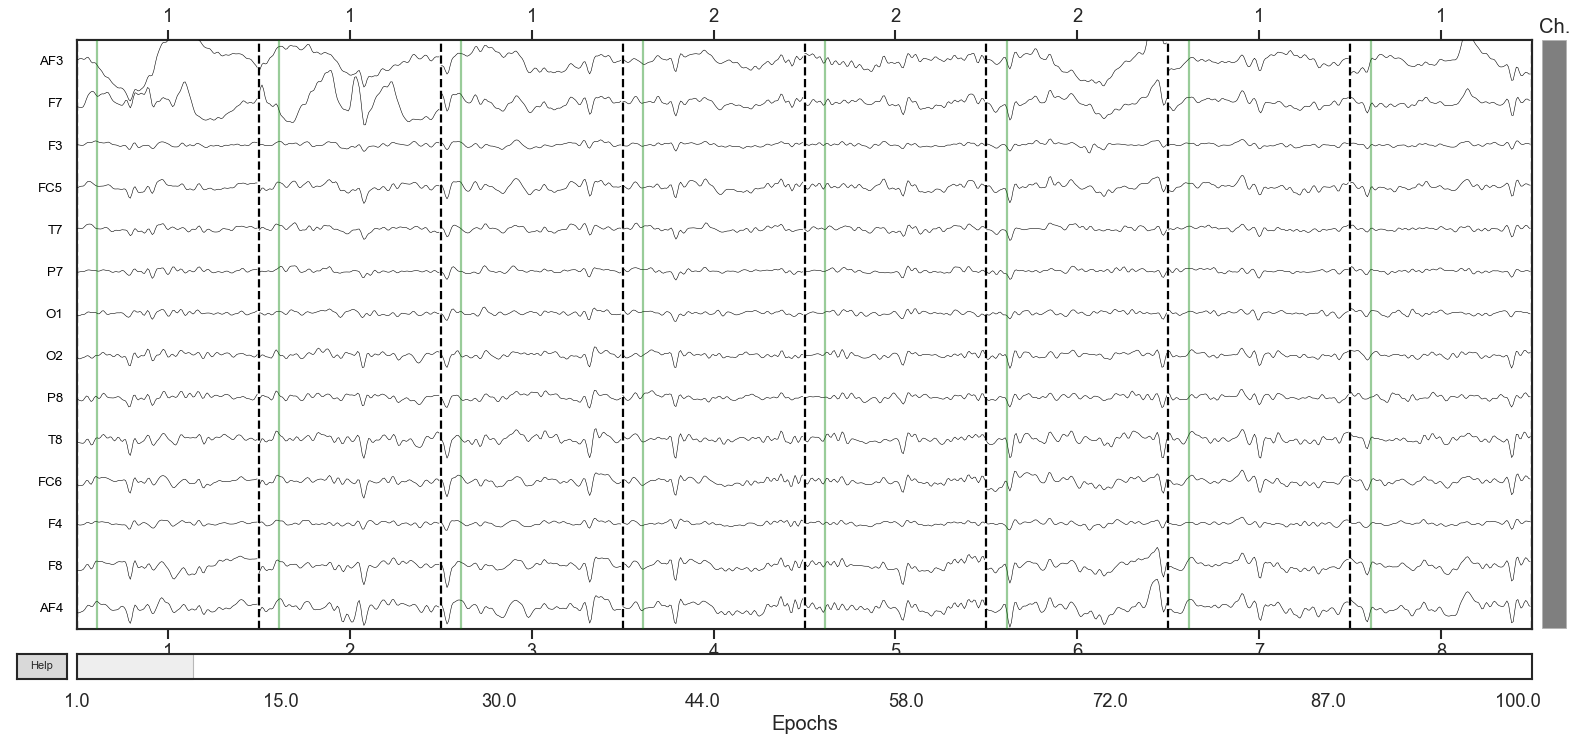

Channels marked as bad: []


In [7]:
# cleanEpochsPlot

%matplotlib
clean_plot = epochs.plot(scalings='auto', n_epochs=8, title="", events=None);
for axis in clean_plot.axes:
    for line in axis.lines:
        line.set_linewidth(2)
clean_plot.show()

In [8]:
#saveEpochs

epochs['House'].save('C:/Users/jdpig/BrainWaves Workspaces/N170 Validate/Data/Subash/EEG/House_2-epo.fif')
epochs['Face'].save('C:/Users/jdpig/BrainWaves Workspaces/N170 Validate/http://localhost:8888/notebooks/notebooks/N170%20Emotiv%20Analysis.ipynb#Data/Subash/EEG/Face_2-epo.fif')

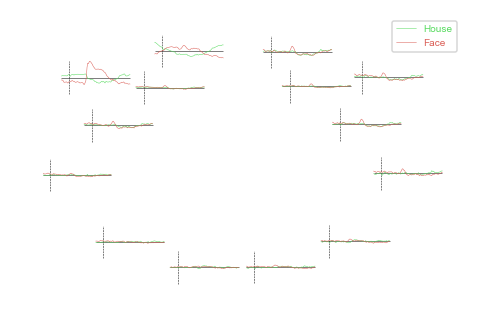

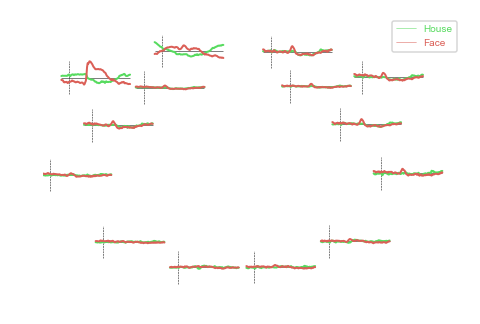

In [4]:
# plotTopoMap

utils.plot_topo(epochs, conditions)

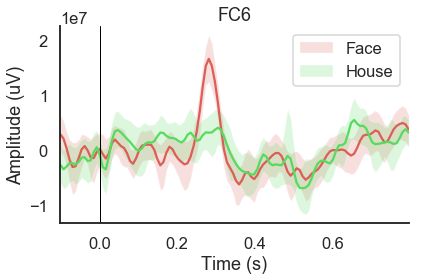

In [33]:
## Plot ERPs

# Input
ch_ind = 10

# Output
X, y = utils.plot_conditions(epochs, ch_ind=ch_ind, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='', diff_waveform=None)